In [4]:
%load_ext autoreload

%autoreload 2

In [5]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch
from celluloid import Camera
from matplotlib.backend_bases import FigureCanvasBase
from matplotlib.animation import FuncAnimation
from IPython.display import clear_output
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import timeit

In [10]:
from src.environment import LogEnv
from src.train import train
from src.architecture import AttentionModel
from src.utils import path_distance
from src.vizualisation import demonstration, action_animation
from src.evaluation import compute_mean_metric, compute_data_metric
from src.or_functions import compute_distance

In [4]:
opts = {'metric': 1.5
        #'demand_type': {'distribution': 'uniform', 'max_demand':10},
        #'tw_type': {'distribution': 'uniform'},
        #"pickup_and_delivery":True
       }

In [5]:
model = AttentionModel().to("cuda")

In [7]:
train(model, opts,'cuda', T=2500, lr=1e-4, batch_size=256)


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


KeyboardInterrupt: 

## Анимация

In [ ]:
opts = {'demand_type': {'distribution': 'uniform', 'max_demand':10},
        #'tw_type': {'distribution': 'uniform'},
        #"pickup_and_delivery":True
       }

In [ ]:
n = 10
batch_size = 1
env = LogEnv(batch_size=batch_size, n=n, opts=opts)

In [ ]:
features, distances, mask = env.reset()

In [ ]:
demonstration(env, opts)

In [ ]:
actions_ext = np.array([2, 7, 3, 5, 1, 0, 6, 8, 9, 4])
action_animation(env, opts, actions_ext, '1-OtOPDTW.gif', 500)

## Проверка модели CVRP, обученной на сервере

In [16]:
f = open('./models/DTSP_20_Nov_28_05_47_34_2020.pkl', 'rb')
weights = pickle.load(f)
f.close()

In [17]:
model = AttentionModel().to("cuda")
model.load_state_dict(weights)

<All keys matched successfully>

In [18]:
model.eval()

AttentionModel(
  (encoder): Encoder(
    (projection): Linear(in_features=7, out_features=128, bias=True)
    (encoder_layers): ModuleList(
      (0): EncoderLayer(
        (lin_q): Linear(in_features=128, out_features=128, bias=True)
        (lin_k): Linear(in_features=128, out_features=128, bias=True)
        (lin_v): Linear(in_features=128, out_features=128, bias=True)
        (lin_o): Linear(in_features=128, out_features=128, bias=True)
        (batch_norm_1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (batch_norm_2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
        )
      )
      (1): EncoderLayer(
        (lin_q): Linear(in_features=128, out_features=128, bias=True)
        (lin_k): Linear(in_features=128, out_fe

In [59]:
opts = {'demand_type': {'distribution': 'uniform', 'max_demand':10, 'capacity':30}
}

In [21]:
%%time
compute_mean_metric(model, batch_size=250, T=40, opts=opts) # 3.84 - оптимальное значение для TSP_20

Wall time: 4.43 s


5.7388179138681865

In [22]:
device = 'cuda'

In [38]:
env = LogEnv(n=20, batch_size=1, opts=opts)

features, distances, mask, context = env.reset()
features = torch.Tensor(features).to(device)
context = torch.Tensor(context).to(device)
flag_done = False
t = 0

while not flag_done:
    v, _ = model(features, mask, t, context, flags=env._flags)
    v = v.to('cpu')
    with torch.no_grad():
        mask, flag_done, context = env.step(v)
        context = torch.Tensor(context).to(device)
    t += 1

route = torch.tensor(env._cur_route, dtype=int)


In [39]:
actions_ext = route.squeeze().tolist()

In [57]:
actions_ext

[20, 0, 12, 17, 14, 13, 18, 10, 5, 6, 2, 9, 3, 15, 1, 8, 7, 16, 4, 11, 19]

current capacity: 27.00


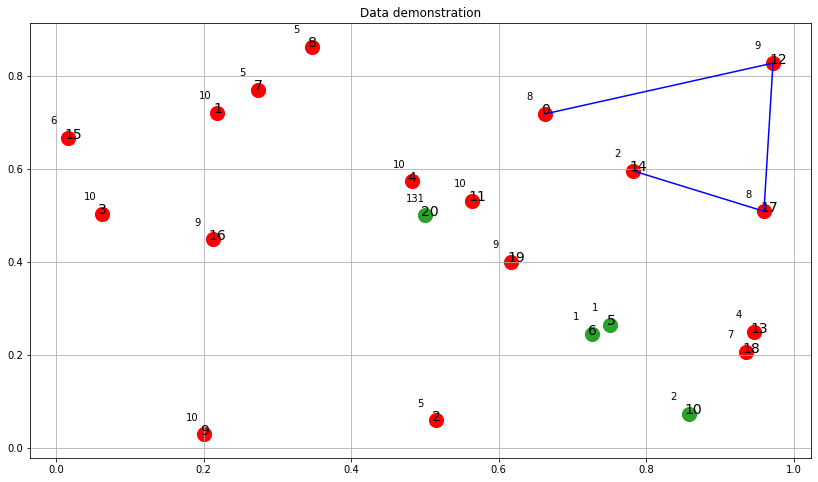

In [ ]:
demonstration(env, opts, actions_ext=None)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


current capacity: 131.00


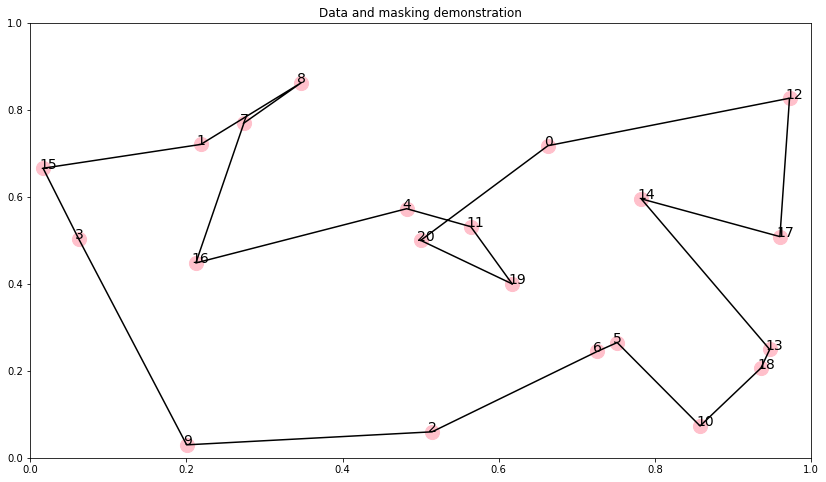

In [40]:
action_animation(env, opts, actions_ext, '1-OtOPDTW.gif', 500)

In [25]:
route

tensor([[20, 17,  5, 12, 11,  4, 13,  2, 14,  7,  8, 18, 10, 16,  6,  9,  1, 15,
          0, 19,  3]])

## Проверка TSP 20 и TSP 50 на реальных данных

### TSP 50

In [7]:
f = open('./data/parsed_data/dataset_50.pkl', 'rb')

dataset_50 = pickle.load(f)

f.close()

f = open('./data/parsed_data/dataset_dist_50.pkl', 'rb')

dataset_dist_50 = pickle.load(f)

f.close()

dist = list(map(lambda x: x[:, :, 0].reshape(-1, 50, 50), dataset_dist_50))
data = list(map(lambda x: {'dots': x.reshape(-1, 50, 2)}, dataset_50))

In [8]:
f = open('./models/TSP_50_Dec__4_18_08_05_2020_1_5.pkl', 'rb')
weights = pickle.load(f)
f.close()

In [11]:
model = AttentionModel().to("cuda")
model.load_state_dict(weights)
model.eval()
print('r')

r


In [13]:
opts = {}
device = 'cuda'

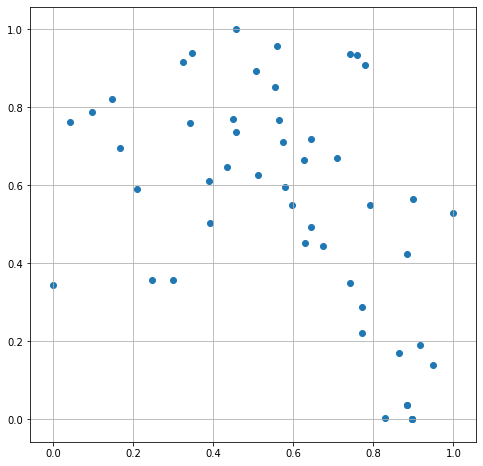

In [11]:
fig = plt.figure(figsize=(8,8))
plt.scatter(data[26]['dots'][0, :, 0], data[26]['dots'][0, :, 1])
plt.grid()

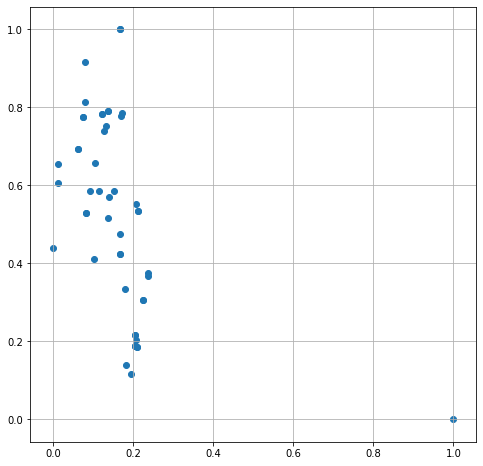

In [12]:
fig = plt.figure(figsize=(8,8))
plt.scatter(data[0]['dots'][0, :, 0], data[0]['dots'][0, :, 1])
plt.grid()

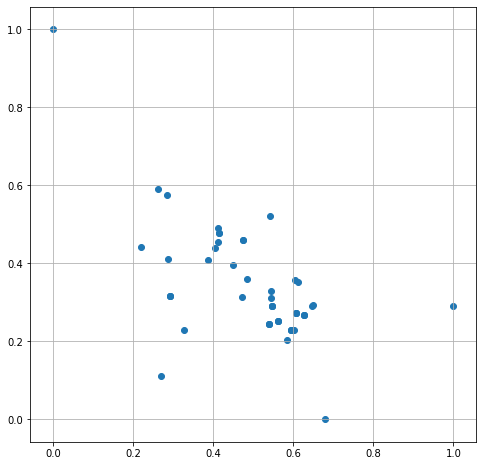

In [13]:
fig = plt.figure(figsize=(8,8))
plt.scatter(data[10]['dots'][0, :, 0], data[10]['dots'][0, :, 1])
plt.grid()

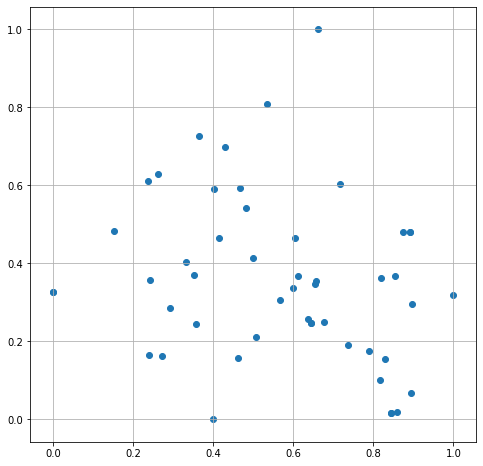

In [14]:
fig = plt.figure(figsize=(8,8))
plt.scatter(data[54]['dots'][0, :, 0], data[54]['dots'][0, :, 1])
plt.grid()

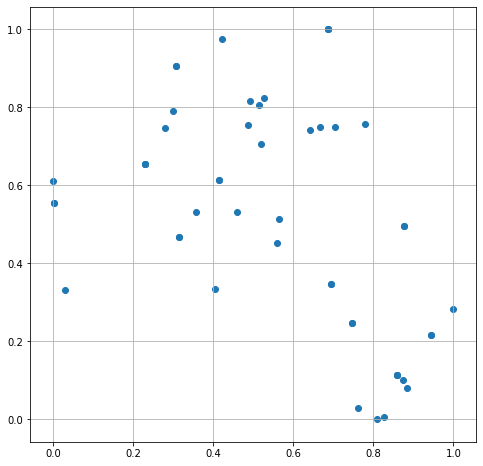

In [15]:
fig = plt.figure(figsize=(8,8))
plt.scatter(data[7]['dots'][0, :, 0], data[7]['dots'][0, :, 1])
plt.grid()

In [14]:
%%time
distances = compute_data_metric(model, data, dist, device, 50, opts)

Wall time: 9.84 s


In [15]:
%%time
or_res = []
avg_time = 6.9/len(data)
for i in range(len(dist)):
    or_res.append(compute_distance(dist[i].reshape(50, 50), eps=1e-2, time_limit=avg_time))

Wall time: 6.99 s


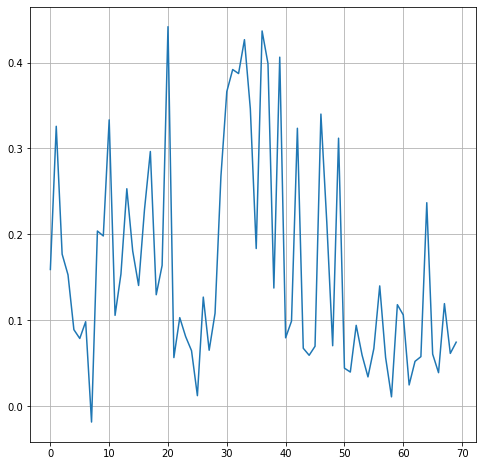

In [17]:
fig = plt.figure(figsize=(8,8))
plt.plot((1 - or_res/distances))
plt.grid()

In [25]:
f = open('./models/TSP_50_Dec__2_03_37_08_2020.pkl', 'rb')
weights = pickle.load(f)
f.close()

In [28]:
model = AttentionModel().to("cuda")
model.load_state_dict(weights)
model.eval()
print('r')

r


In [29]:
%%time
distances = compute_data_metric(model, data, dist, device, 50, opts)

Wall time: 6.86 s


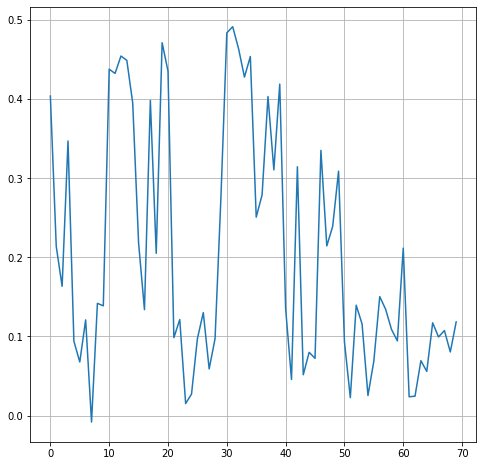

In [30]:
fig = plt.figure(figsize=(8,8))
plt.plot((1 - or_res/distances))
plt.grid()